# Extension to Exotics and Volatility Surface Calibration

This notebook focuses on extension of main notebook to mainly two aspects:
- Exotic options pricing (focus on barrier option)

## Barrier Option Pricing
**Why do we need to care extra:**

Barriers are path-dependent options, their payoffs depend on the path, not only the final payoff

**Methodology**
1. Closed-Form: Reiner-Rubenstein
2. Monte-Carlo Simulation

There are four barrier types: down-in, downn-out, up-in, up-out. Assume current price at S_0 and barrier B. If S_0 < B, then down-out is automatically zero. If S_0 > B, then up-out is zero. 

结果展示：
- 画一张 vanilla vs barrier payoff（横轴 S_T）。
- 再画一张 Delta 对比（barrier 的 Delta 在接近障碍附近会出现非平滑/跳变），凸显对冲难度。


In [23]:
%load_ext autoreload
%autoreload 2

In [38]:
S0 = 100
K = 100
r = 0.02
q = 0
sigma = 0.2
T = 1
steps = 50 
seed = 12345

In [62]:
from deriv_pricing.barrier import mc_barrier_knockout_call, price_barrier_rr
from deriv_pricing.monte_carlo import mc_european_call
from deriv_pricing.black_scholes import bs_european_option
import matplotlib.pyplot as plt
import pandas as pd

### Barrier Payoff

Text(0, 0.5, 'Option Payoff')

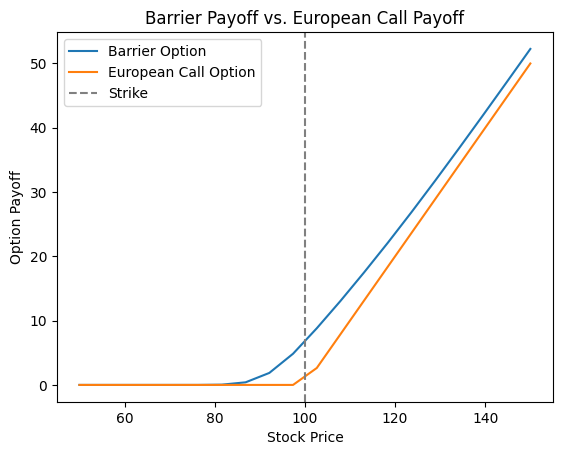

In [58]:
# Payoff Comparison
S_list = np.linspace(50, 150, 20)
barrier_list = []
call_list = []

for s in S_list:
    mc_barrier, mc_barrier_stdder = mc_barrier_knockout_call(s, K, B, r, q, sigma, T, int(1e5), 10, False, seed)
    barrier_list.append(mc_barrier)
    call_list.append(np.maximum(s-K, 0.0))


plt.plot(S_list, barrier_list, label = 'Barrier Option')
plt.plot(S_list, call_list, label = 'European Call Option')
plt.title('Barrier Payoff vs. European Call Payoff')
plt.axvline(K, color="gray", linestyle="--", label="Strike")
plt.legend()
plt.xlabel('Stock Price')
plt.ylabel('Option Payoff')

### Barrier Pricing 3-D Plot

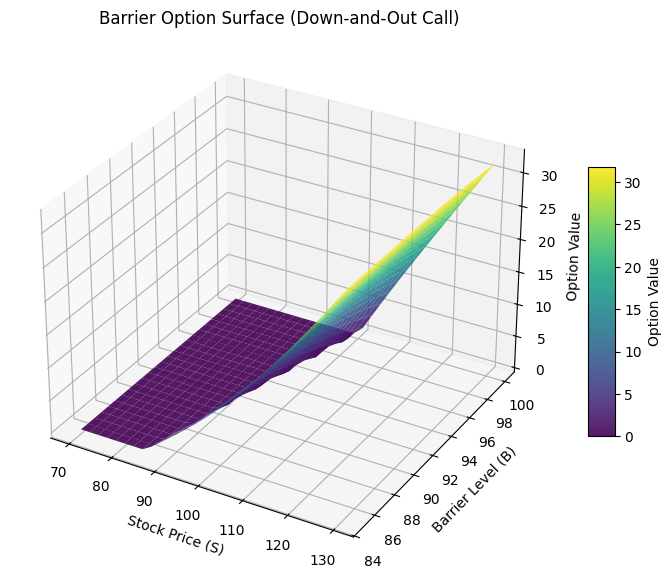

In [109]:
import numpy as np

S_list = np.linspace(70, 130, 30)   # 标的价格区间
B_list = np.linspace(85, 100, 25)   # 障碍区间（Down-and-Out, B < S0）

V_surface = np.zeros((len(B_list), len(S_list)))

for i, B in enumerate(B_list):
    for j, S in enumerate(S_list):
        V_surface[i, j] = price_barrier_rr(S, K, B, r, q, sigma, T, 'call', 'down', 'out')

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # 注册3D绘图工具

S_mesh, B_mesh = np.meshgrid(S_list, B_list)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(S_mesh, B_mesh, V_surface,
                       cmap='viridis', edgecolor='none', alpha=0.9)

ax.set_xlabel('Stock Price (S)')
ax.set_ylabel('Barrier Level (B)')
ax.set_zlabel('Option Value')
ax.set_title('Barrier Option Surface (Down-and-Out Call)')

fig.colorbar(surf, shrink=0.5, aspect=10, label='Option Value')
plt.show()


### Barrier Price Comparison: Closed-form and Monte-Carlo

In [54]:
# Down-out
B = 95

clsoed_form_barrier = price_barrier_rr(S0, K, B, r, q, sigma, T, 'call', 'down', 'out')
mc_barrier, mc_barrier_stdder = mc_barrier_knockout_call(S0, K, B, r, q, sigma, T, int(1e5), 10, False, seed)

print(f'Closed form barrier option price for B={B} and K={K} is: {clsoed_form_barrier}')
print(f'Monte Carlo barrier option price for B={B} and K={K} is: {mc_barrier}')

Closed form barrier option price for B=95 and K=100 is: 4.674776282541135
Monte Carlo barrier option price for B=95 and K=100 is: 6.775525717691274


**Where does this difference come from?**
1. Under the Black–Scholes framework, the Reiner–Rubinstein formula provides the true analytical solution for continuously monitored single-barrier options.
2. The Monte Carlo method tends to overprice compared to the continuous RR model due to missed intra-step barrier hits — but as step size decreases or with Brownian Bridge correction, it converges to the RR price.

Text(0, 0.5, 'Barrier Option Value')

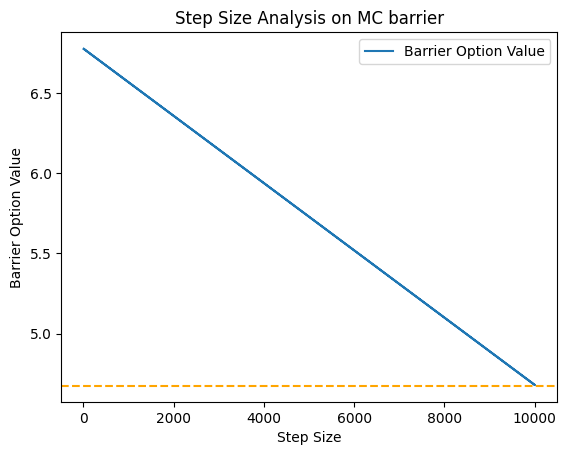

In [61]:
# Reduce step size for MC

step_size_list = [10, 10000, 10]
barrier_list = []

for step in step_size_list:
    mc_barrier, mc_barrier_stdder = mc_barrier_knockout_call(S0, K, B, r, q, sigma, T, int(1e5), step, False, seed)
    barrier_list.append(mc_barrier)

plt.plot(step_size_list, barrier_list, label = 'Barrier Option Value')
plt.axhline(clsoed_form_barrier, linestyle = '--', c='orange')
plt.title('Step Size Analysis on MC barrier')
plt.legend()
plt.xlabel('Step Size')
plt.ylabel('Barrier Option Value')

## Barrier Option Hedging

In [63]:
# Delta Hedge

#Greeks
from deriv_pricing.greeks import delta_fd, gamma_fd, vega_fd

# Greeks from finite difference
h = 1e-4
delta_pricer = lambda s: price_barrier_rr(s, K, B, r, q, sigma, T, 'call', 'down', 'out')
fd_delta_call = delta_fd(delta_pricer, S0, h)
fd_gamma_call = gamma_fd(delta_pricer, S0, h)
vega_pricer = lambda sigma: price_barrier_rr(S0, K, B, r, q, sigma, T, 'call', 'down', 'out')
fd_vega_call = vega_fd(vega_pricer, sigma, h)


fd_greeks = [fd_delta_call, fd_gamma_call, fd_vega_call]

greeks_df = pd.DataFrame(
    {
        'Finite-Difference Greeks': fd_greeks
    },
    index = ['Delta', 'Gamma', 'Vega']
)

greeks_df

,Finite-Difference Greeks
Delta,0.919652
Gamma,-0.004400
Vega,2.644693


In [93]:
from deriv_pricing.black_scholes import bs_european_greeks
bs_delta, bs_gamma, bs_vega = bs_european_greeks(S0, K, r, q, sigma, T, 'call')
vanilla_greeks = {'Delta': bs_delta, 'Gamma': bs_gamma, 'Vega': bs_vega}

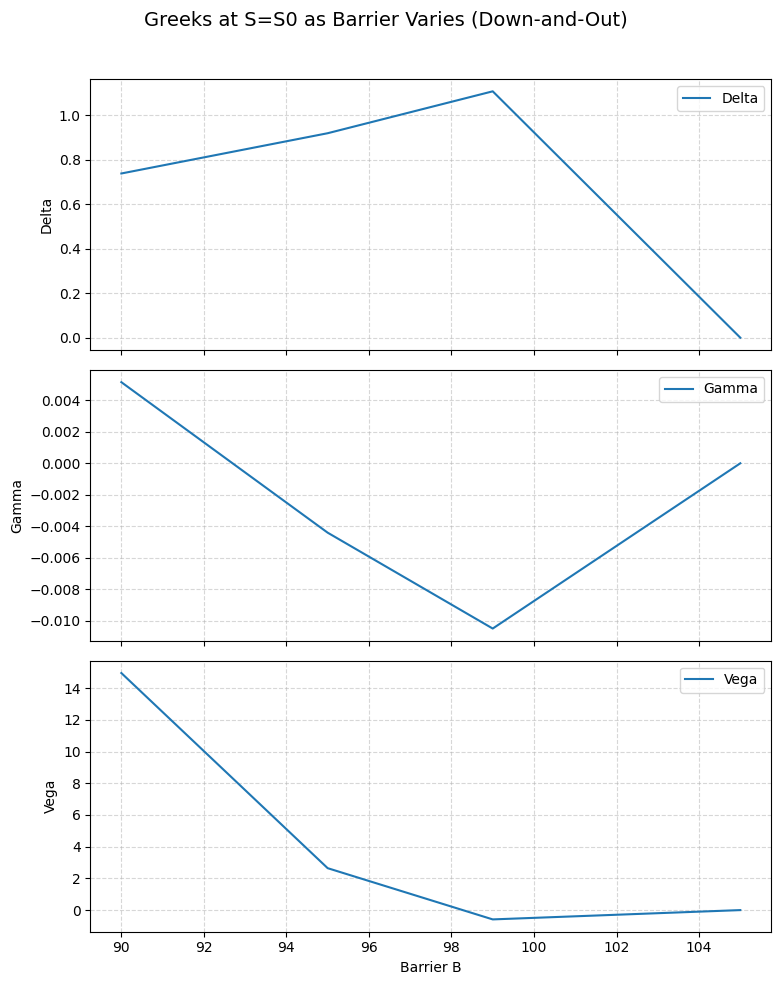

In [104]:
# 
B_list = [90, 95, 99, 105]

barrier_greeks = {'Delta': [], 'Gamma': [], 'Vega': []}

for B in B_list:
    delta_pricer = lambda s: price_barrier_rr(s, K, B, r, q, sigma, T, 'call', 'down', 'out')
    fd_delta_call = delta_fd(delta_pricer, S0, h)
    fd_gamma_call = gamma_fd(delta_pricer, S0, h)
    vega_pricer = lambda sigma: price_barrier_rr(S0, K, B, r, q, sigma, T, 'call', 'down', 'out')
    fd_vega_call = vega_fd(vega_pricer, sigma, h)

    barrier_greeks['Delta'].append(fd_delta_call)
    barrier_greeks['Gamma'].append(fd_gamma_call)
    barrier_greeks['Vega'].append(fd_vega_call)

fig, axes = plt.subplots(3, 1, figsize=(8, 10), sharex=True)

greeks = ['Delta', 'Gamma', 'Vega']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']   # 蓝 橙 绿，清晰区分障碍

for i, greek in enumerate(greeks):
    ax = axes[i]
    ax.plot(B_list, barrier_greeks[greek], label = greek)
    ax.set_ylabel(greek)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend(loc='best')
    #ax.axvline(S0, color = 'gray', linestyle='--', label='S0')
    ax.legend()

fig.suptitle('Greeks at S=S0 as Barrier Varies (Down-and-Out)', fontsize=14)
axes[-1].set_xlabel('Barrier B')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
    


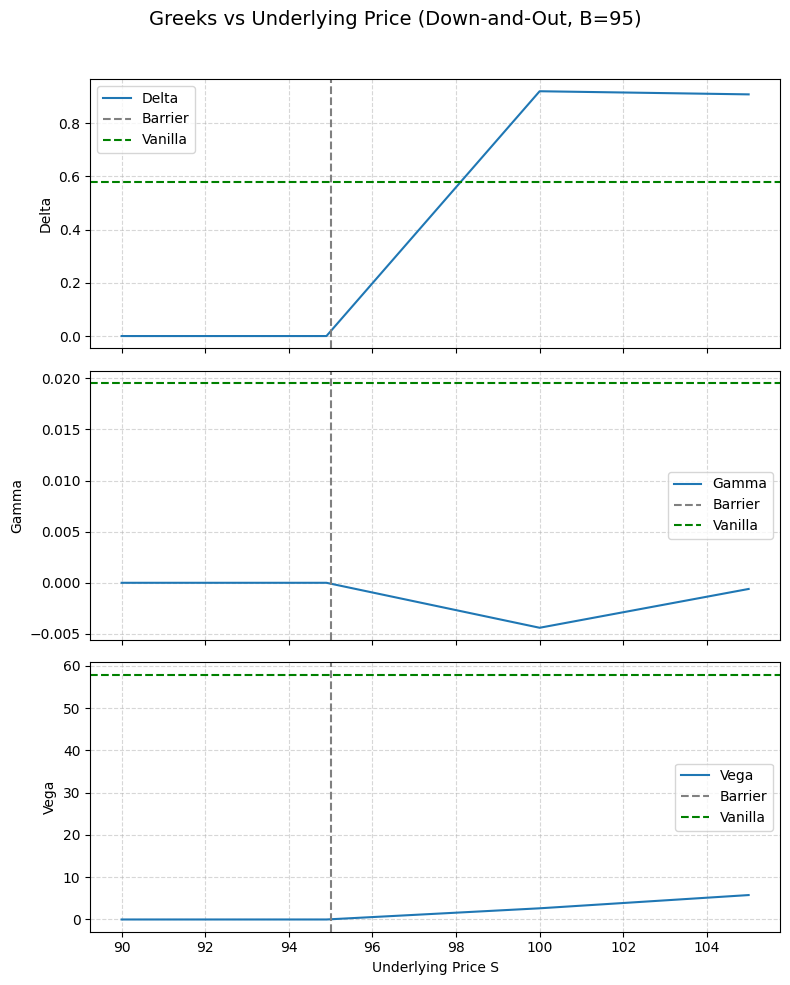

In [99]:
B = 95
S_list = [90, 94.9, 100, 105]

barrier_greeks = {'Delta': [], 'Gamma': [], 'Vega': []}

for S in S_list:
    delta_pricer = lambda s: price_barrier_rr(s, K, B, r, q, sigma, T, 'call', 'down', 'out')
    fd_delta_call = delta_fd(delta_pricer, S, h)
    fd_gamma_call = gamma_fd(delta_pricer, S, h)
    vega_pricer = lambda sigma: price_barrier_rr(S, K, B, r, q, sigma, T, 'call', 'down', 'out')
    fd_vega_call = vega_fd(vega_pricer, sigma, h)

    barrier_greeks['Delta'].append(fd_delta_call)
    barrier_greeks['Gamma'].append(fd_gamma_call)
    barrier_greeks['Vega'].append(fd_vega_call)


fig, axes = plt.subplots(3, 1, figsize=(8, 10), sharex=True)

greeks = ['Delta', 'Gamma', 'Vega']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']   # 蓝 橙 绿，清晰区分障碍

for i, greek in enumerate(greeks):
    ax = axes[i]
    ax.plot(S_list, barrier_greeks[greek], label = greek)
    ax.set_ylabel(greek)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend(loc='best')
    ax.axvline(B, color = 'gray', linestyle='--', label='Barrier')
    ax.axhline(vanilla_greeks[greek], linestyle='--', color='green', label='Vanilla')
    ax.legend()
    
fig.suptitle('Greeks vs Underlying Price (Down-and-Out, B=95)', fontsize=14)
axes[-1].set_xlabel('Underlying Price S')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

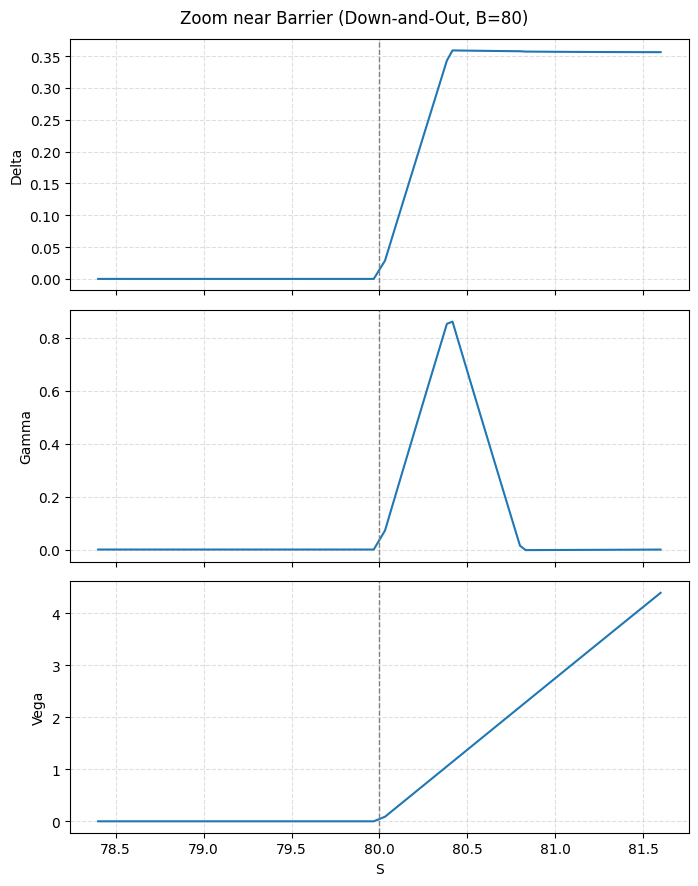

In [128]:
# 近障碍放大图
eps = 1e-6
S_zoom = np.linspace(B*0.98, B*1.02, 101)
S_zoom = S_zoom[np.abs(S_zoom - B) > eps]   # 删掉恰好等于 B 的点

def greeks_at_S(S, B, T):
    h_S     = max(0.25, 0.005*S)
    h_sigma = 0.01

    # pricers
    price_S = lambda s: price_barrier_rr(s, K, B, r, q, sigma, T, 'call', 'down', 'out')
    price_V = lambda vol: price_barrier_rr(S, K, B, r, q, vol,  T, 'call', 'down', 'out')

    if S <= B:       # 连续监测 DO，障碍内侧直接为 0
        delta = gamma = vega = 0.0
    else:
        if abs(S - B) >= 2*h_S:
            # 中央差分
            delta = (price_S(S + h_S) - price_S(S - h_S)) / (2*h_S)
            gamma = (price_S(S + h_S) - 2*price_S(S) + price_S(S - h_S)) / (h_S**2)
        else:
            # 单边差分（向远离障碍侧）
            delta = (price_S(S) - price_S(S - h_S)) / h_S     # backward
            # Gamma 用二阶单边（或退而用更大的 h_S 做中央）
            gamma = (price_S(S) - 2*price_S(S - h_S) + price_S(S - 2*h_S)) / (h_S**2)

        vega = (price_V(sigma + h_sigma) - price_V(sigma - h_sigma)) / (2*h_sigma)

    return delta, gamma, vega

results = [greeks_at_S(i, B, T) for i in S_zoom]
deltas, gammas, vegas = zip(*results)
deltas = np.array(deltas)
gammas = np.array(gammas)
vegas  = np.array(vegas)


fig, axes = plt.subplots(3, 1, figsize=(7, 9), sharex=True)
axes[0].plot(S_zoom, deltas);  axes[0].set_ylabel('Delta')
axes[1].plot(S_zoom, gammas);  axes[1].set_ylabel('Gamma')
axes[2].plot(S_zoom, vegas);   axes[2].set_ylabel('Vega'); axes[2].set_xlabel('S')
for ax in axes: 
    ax.grid(True, ls='--', alpha=0.4)
    ax.axvline(B, color='gray', ls='--', lw=1)
fig.suptitle(f'Zoom near Barrier (Down-and-Out, B={B})'); plt.tight_layout()


**Conclusion:**
Barrier options are path-dependent, and the greeks plotted above showcase the difficulty to hedge barrier options comparing with vanilla options given this nature. There are kinks at where Barrier is close to S, where one should rely on scenario analysis rather than single-point greeks.

太好了，这一块正是 barrier 真正“有交易味儿”的地方。下面我把卖方常用的对冲框架和你可以**自己动手模拟**的方案拆开讲：用什么 hedge、PnL 怎么拆、smile dynamics 怎么落地到代码里。不给你整段成品代码，但给到可直接照抄的步骤/伪代码骨架。

---

### 交易台如何 hedge barrier（直观版）

**核心思路：分层对冲**

* **Delta**：用标的（或期货）做**高频动态对冲**。靠近障碍时 Δ 非平滑、Γ 尖，所以调仓频率↑、成本↑。
* **Vega/Smile**：用**香草组合**（几只 vanilla，不同 K/T）做**半静态**或低频动态对冲，尽量匹配 Vega、Vanna、Volga。
* **Barrier 风险**：用 **one-touch/no-touch**、**digitals** 或 **镜像 vanilla 组合**做半静态复制/保护（触碰日要考虑 **unwind** 成本和 gap risk）。
* **监控**：Δ/Γ/Vega/Theta/Vanna/Volga + **Hit prob**（触碰概率）、**Expected Unwind P&L**、以及 **smile dynamics 假设**（sticky-delta vs sticky-strike）下的敏感度差异。


### P&L 分解

对一个只做了 Δ-hedge 的账本，离散对冲的单步 P&L 近似：PnLt→t+Δt​≈1/2​ΓS^2σ^2Δt+Vega⋅Δσ+ΘΔt−交易成本
  若 barrier 被触发（knock-out）：
- 期权价值瞬间 → 0；
- 你要**立刻平掉**手里的对冲（标的 + 香草），这笔平仓差额就是 **Unwind P&L**；
- knock-out 前后的 **gap**（周末/夜间）是重要风险来源。

> 做到 **Δ+Vega** 同时对冲时，剩余 P&L 主要来自 Γ（离散对冲误差）、Vanna/Volga（smile 动态错配）、Theta 与成本。


### “半静态复制”怎么落地（加分项）

以 **down-and-out call（B<K）** 为例：

* 课本里可用 **vanilla at K** 与一个 **“镜像” vanilla at $K^*=\frac{B^2}{K}$** 的组合近似复制（权重来自 RR 公式里你已经用到的 (S_fac, K_fac) 系数）。
* **未触碰**：组合价值在到期趋近真实 DO；
* **触碰时**：组合需要 **unwind**（这就是 Expected Unwind P&L），高度依赖 **smile dynamics** 与市场流动性。
* 在模拟里：建这个静态组合，**不做 vega 动态**，仅做 Δ-对冲，并在触碰日平仓 → 比较总 P&L 与动态 Vega 对冲方案。

### smile dynamics 怎么“解释 + 实现”

* **Sticky-strike**：市场把“某个固定 K 的 IV”当作“属性”，价格动了也不改这点的 IV。

  * **实现**：σ_t(K) = σ_0(K)。
  * **含义**：标的上移后，同一个 K 变得更 ITM/OTM，但仍用原来的 σ。
* **Sticky-delta**：市场把“某个 Delta 的 IV”当作“属性”，随标的移动，整个 smile 在 **strike 轴上平移**。

  * **实现**（简单近似）：σ_t(K) = σ_0(K·S_t/S_0)；或每次用“同 Delta”的 K 查 σ。
  * **影响**：Vanna/Volga 暴露不同，hedge 组合在两种假设下 P&L 差异显著（面试高频考点）。

> 你的报告里可以写：**“我们在两种极端假设（sticky-strike / sticky-delta）下跑情景，观察 Vanna/Volga P&L 的方向性差异，从而说明 smile 动态是 barrier 对冲的关键不确定性。”**


### Hedging Simulation with PnL tracking

In [129]:
B = 80

def hedging_simulation(S0, K, B, r, q, sigma, T, n_steps, antithetic, seed, barrier_type):
    dt = T / n_steps

    rng = np.random.default_rng(seed)
    if antithetic:
        z = rng.standard_normal(n_steps)
        z = np.concatenate([z, -z])
    else:
        z = rng.standard_normal(n_steps)
    
    PnL_book = {
        't': [],
        'Underlying Position': [],
        'Cash Position': []
    }

    S = S0
    cash = 0.0
    pos_under = 0.0
    knocked = False # check if the option is knocked

    for t in range(0, n_steps):
    # every time step: 
    # 1. check barrier violation 2. compute greeks 3. if violated, flat all current positions 4. if not violated, use delta to flatten
        PnL_book['t'].append(t)

        S *= np.exp((r - q - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z[t])
        print(S)

        if (barrier_type == 'down' and S<=B) or (barrier_type == 'up' and S>=B): # down-out
        # Barrier Option Value = 0, flat all underlying positions
            knocked = True
            option_val = 0.0
            cash += pos_under * S # flat underlying position
            pos_under = 0.0
            # 记录并退出
            PnL_book['Underlying Position'].append(pos_under)
            PnL_book['Cash Position'].append(cash)
            break

        # didnt break

        delta, gamma, vega = greeks_at_S(S, B)

        # underlying HC
        target_under = -delta # flat delta
        trade = target_under - pos_under

        # Cash HC
        cash -= trade * S # if trade is positive, then we need to buy, else sell
        cash *= np.exp(r*dt)
        #cash += pos_under * q * S_prev

        # Update Book
        pos_under = target_under # at this time, how much delta for this option

        # 记录
        PnL_book['Underlying Position'].append(pos_under)
        PnL_book['Cash Position'].append(cash)

    if not knocked:
        option_val = price_barrier_rr(S, K, B, r, q, sigma, T - t*dt, 'call', barrier_type, 'out')
        portfolio = option_val + pos_under * S + cash
    else:
        portfolio = cash

    return portfolio, PnL_book



In [126]:
hedging_simulation(S0, K, B, r, q, sigma, T, 10, False, seed, 'down')

91.38849396082955
98.99256925882462
93.68886130733573
92.16567303632202
91.72753642058106
87.52854446516992
80.2749933015579
83.63798147464985
85.56985508262349
75.62774068252044


(np.float64(8.24324533404333),
 {'t': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
  'Underlying Position': [np.float64(-0.444838706016753),
   np.float64(-0.5749155267034323),
   np.float64(-0.48202074409382367),
   np.float64(-0.45703022013745725),
   np.float64(-0.45010419207947344),
   np.float64(-0.3925365135090486),
   np.float64(-0.2461202821492334),
   np.float64(-0.36079337706947656),
   np.float64(-0.3732698924438463),
   0.0],
  'Cash Position': [np.float64(40.73452703766207),
   np.float64(53.71849534374154),
   np.float64(45.10540960816241),
   np.float64(42.887831091870325),
   np.float64(42.33711320954559),
   np.float64(37.37296933858176),
   np.float64(25.670697434618102),
   np.float64(35.33231764093096),
   np.float64(36.47280396437883),
   np.float64(8.24324533404333)]})

In [169]:
def hedging_simulation(S0, K, B, r, q, sigma, T, n_steps, antithetic, seed, barrier_type):
    dt = T / n_steps

    rng = np.random.default_rng(seed)
    if antithetic:
        z = rng.standard_normal(n_steps//2)
        z = np.concatenate([z, -z])
    else:
        z = rng.standard_normal(n_steps)
    
    PnL_book = {
    't': [],
    'S': [],
    'Delta Barrier': [],
    'Delta Van1': [],
    'Delta Van2': [],
    'Underlying Position': [],
    'Vanilla1 Position': [],
    'Vanilla2 Position': [],
    'Cash': [],
    'Net Delta Before': [],
    'Net Delta Mid': [],
    'Net Delta After': [],
    'Portfolio Value': []
}

    S = S0
    cash = 0.0
    pos_under = 0.0
    knocked = False # check if the option is knocked

    # Choose hedging vanillas
    K1, K2 = 100, 110   # 例如：ATM 与 OTM call
    tau = T      

    # 初始持仓（权重稍后算）
    pos_van1 = 0.0
    pos_van2 = 0.0

    delta_ba = 0.0
    delta_1, delta_2 = 0.0, 0.0


    for t in range(0, n_steps):
    # every time step: 
    # 1. check barrier violation 2. compute greeks 3. if violated, flat all current positions 4. if not violated, use delta to flatten
        PnL_book['t'].append(t)

        tau = T - (t+1)*dt     # 用 step 末的剩余到期

        S *= np.exp((r - q - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z[t])
        V1 = bs_european_option(S, K1, r, q, sigma, tau, 'call')
        delta_1, _, vega_1 = bs_european_greeks(S, K1, r, q, sigma, tau, 'call')
        V2 = bs_european_option(S, K2, r, q, sigma, tau, 'call')
        delta_2, _, vega_2 = bs_european_greeks(S, K2, r, q, sigma, tau, 'call')

        PnL_book['S'].append(S)

        delta_ba, _, vega_ba = greeks_at_S(S, B, tau)
    
        PnL_book['Delta Barrier'].append(delta_ba)
        PnL_book['Delta Van1'].append(delta_1)
        PnL_book['Delta Van2'].append(delta_2)

        net_delta_before = delta_ba + pos_van1*delta_1 + pos_van2*delta_2 + pos_under
        PnL_book['Net Delta Before'].append(net_delta_before) 
        


        if (barrier_type == 'down' and S<=B) or (barrier_type == 'up' and S>=B): # down-out
        # Barrier Option Value = 0, flat all underlying positions
            knocked = True
            option_val = 0.0
            cash += pos_under * S + pos_van1 * V1 + pos_van2 * V2 # flat underlying position
            pos_under = pos_van1 = pos_van2 = 0.0
            option_val = 0.0

            # 记录并退出
            PnL_book['Underlying Position'].append(pos_under)
            PnL_book['Cash'].append(cash)
            PnL_book['Vanilla1 Position'].append(pos_van1)
            PnL_book['Vanilla2 Position'].append(pos_van2)
            PnL_book['Portfolio Value'].append(cash)
            PnL_book['Net Delta Mid'].append(net_delta_before)
            PnL_book['Net Delta After'].append(0)

            break

        # didnt break

        # Flat vega
        A = np.array([[vega_1, vega_2]])
        b = np.array([-vega_ba])
        if abs(vega_1) + abs(vega_2) < 1e-8:
            w1 = w2 = 0.0
        else:
            w1, w2 = np.linalg.lstsq(A, b, rcond=None)[0]

        target_van1 = w1
        target_van2 = w2
        trade_van1 = target_van1 - pos_van1
        trade_van2 = target_van2 - pos_van2
        cash -= trade_van1 * V1 + trade_van2 * V2   # 买卖 vanilla 对冲 vega
        pos_van1, pos_van2 = target_van1, target_van2

        PnL_book['Vanilla1 Position'].append(pos_van1)
        PnL_book['Vanilla2 Position'].append(pos_van2)

        # Flat delta
        delta_total = delta_ba + pos_van1 * delta_1 + pos_van2 * delta_2 # current total delta
        net_delta_mid = delta_total + pos_under
        PnL_book['Net Delta Mid'].append(net_delta_mid)


        # underlying HC
        target_under = -delta_total # flat delta
        trade = target_under - pos_under

        # Cash HC
        cash -= trade * S # if trade is positive, then we need to buy, else sell
        cash *= np.exp(r*dt)
        #cash += pos_under * q * S_prev

        # Update Book
        pos_under = target_under # at this time, how much delta for this option

        # 记录
        PnL_book['Underlying Position'].append(pos_under)
        PnL_book['Cash'].append(cash)
        #PnL_book['Net Delta Exposure'].append(delta_total + pos_under)

        option_val = price_barrier_rr(S, K, B, r, q, sigma, tau, 'call', barrier_type, 'out')
        portfolio_val  = option_val + pos_under*S + cash + pos_van1*V1 + pos_van2*V2
        PnL_book['Portfolio Value'].append(portfolio_val)

        net_delta_after = delta_ba + pos_van1*delta_1 + pos_van2*delta_2 + pos_under
        PnL_book['Net Delta After'].append(net_delta_after)

    if not knocked:
        Vb = max(S - K, 0.0)
        V1 = max(S - K1, 0.0)
        V2 = max(S - K2, 0.0)
        portfolio = Vb + pos_under * S + cash + V1 * pos_van1 + V2 * pos_van2
    else:
        portfolio = cash

    return portfolio, PnL_book

In [170]:
potfolio, PnL_book = hedging_simulation(S0, K, B, r, q, sigma, T, 10, False, seed, 'down')

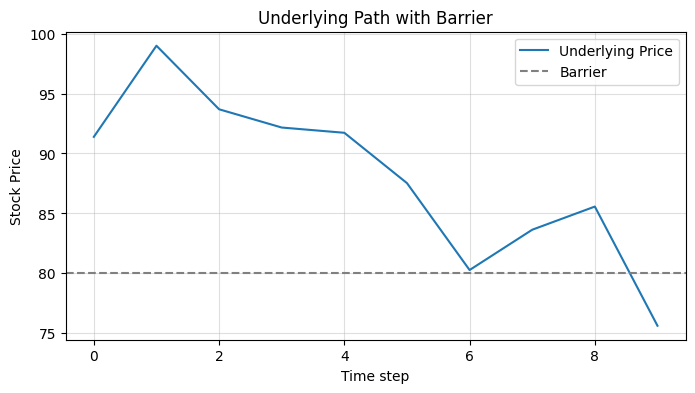

In [162]:
plt.figure(figsize=(8,4))
plt.plot(PnL_book['t'], PnL_book['S'], label='Underlying Price')
plt.axhline(B, color='gray', linestyle='--', label='Barrier')
plt.title('Underlying Path with Barrier')
plt.xlabel('Time step')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(alpha=0.4)


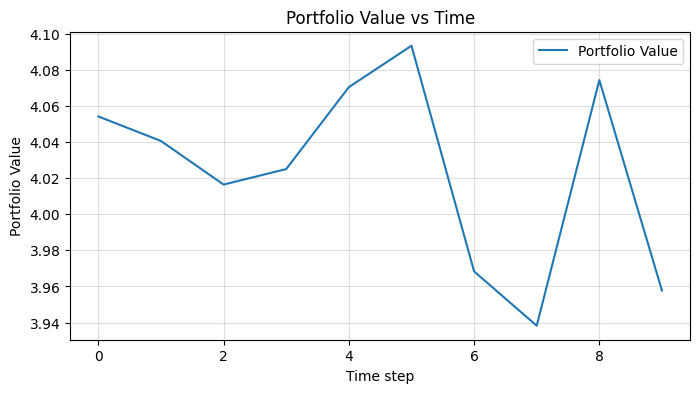

In [154]:
plt.figure(figsize=(8,4))
plt.plot(PnL_book['t'], PnL_book['Portfolio Value'], label='Portfolio Value')
plt.title('Portfolio Value vs Time')
plt.xlabel('Time step')
plt.ylabel('Portfolio Value')
plt.legend()
plt.grid(alpha=0.4)


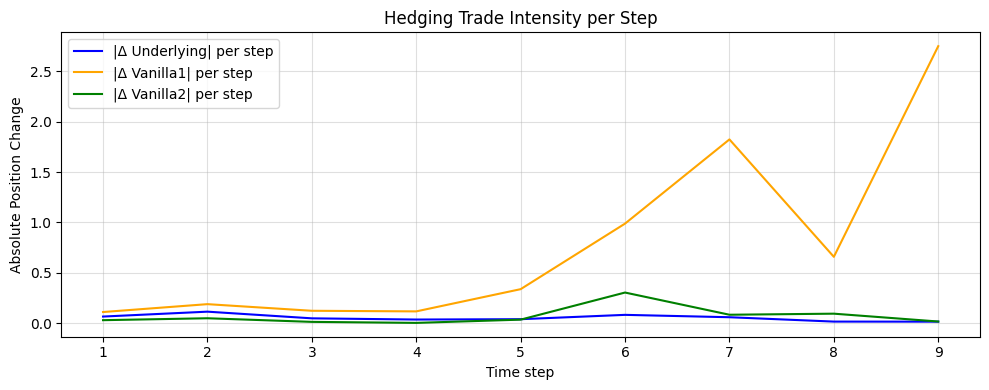

In [179]:
trades_under = np.abs(np.diff(PnL_book['Underlying Position']))
trades_van1  = np.abs(np.diff(PnL_book['Vanilla1 Position']))
trades_van2  = np.abs(np.diff(PnL_book['Vanilla2 Position']))

plt.figure(figsize=(10,4))
plt.plot(PnL_book['t'][1:], trades_under, color='blue', label='|Δ Underlying| per step')
plt.plot(PnL_book['t'][1:], trades_van1, color='orange', label='|Δ Vanilla1| per step')
plt.plot(PnL_book['t'][1:], trades_van2, color='green', label='|Δ Vanilla2| per step')
plt.xlabel('Time step')
plt.ylabel('Absolute Position Change')
plt.title('Hedging Trade Intensity per Step')
plt.legend()
plt.grid(alpha=0.4)
plt.tight_layout()


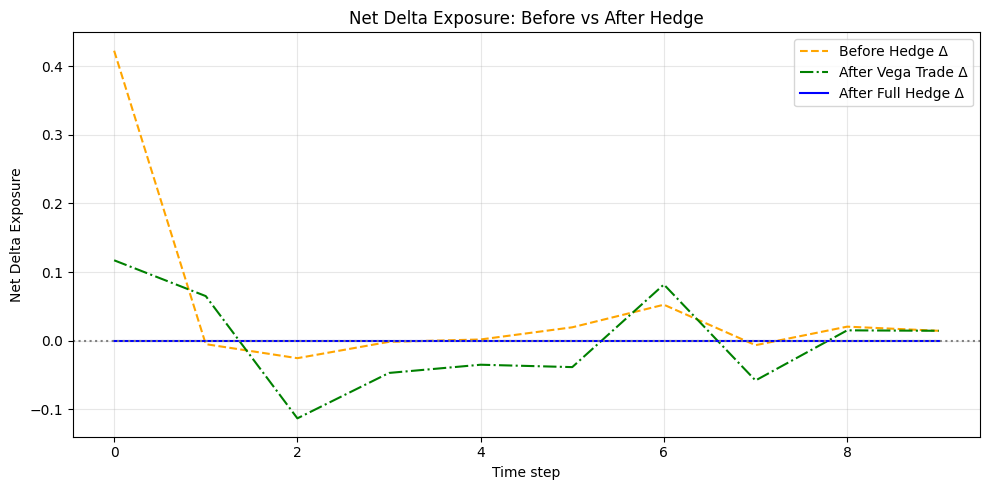

In [171]:
plt.figure(figsize=(10,5))
plt.plot(PnL_book['t'], PnL_book['Net Delta Before'], '--', color='orange', label='Before Hedge Δ')
plt.plot(PnL_book['t'], PnL_book['Net Delta Mid'], '-.', color='green', label='After Vega Trade Δ')
plt.plot(PnL_book['t'], PnL_book['Net Delta After'], '-', color='blue', label='After Full Hedge Δ')
plt.axhline(0, color='gray', linestyle=':')
plt.xlabel('Time step')
plt.ylabel('Net Delta Exposure')
plt.title('Net Delta Exposure: Before vs After Hedge')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()


/var/folders/zg/4k9h9dqx08q8fyj24lyqs5_40000gp/T/ipykernel_2880/985556923.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


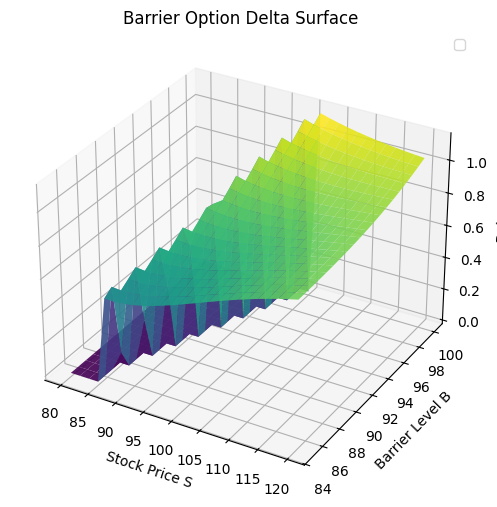

In [178]:
S_list = np.linspace(80, 120, 25)
B_list = np.linspace(85, 100, 20)
Delta_surface = np.zeros((len(B_list), len(S_list)))

for i, B_ in enumerate(B_list):
    for j, S_ in enumerate(S_list):
        Delta_surface[i,j],_,_ = greeks_at_S(S_, B_, T)

S_mesh, B_mesh = np.meshgrid(S_list, B_list)
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(S_mesh, B_mesh, Delta_surface, cmap='viridis', alpha=0.9)
ax.set_xlabel('Stock Price S')
ax.set_ylabel('Barrier Level B')
ax.set_zlabel('Delta')
ax.set_title('Barrier Option Delta Surface')
plt.legend()
plt.show()
